In [2]:
import pandas as pd
df = pd.read_csv("IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def split_data(df, train_frac=0.7, val_frac=0.15, test_frac=0.15):
    train_df, temp_df = train_test_split(df, test_size=1 - train_frac, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=test_frac / (test_frac + val_frac), random_state=42)
    return train_df, val_df, test_df

def encode_labels(train_df, test_df, val_df, target_feature):
    label_encoder = LabelEncoder()
    label_encoder.fit(train_df[target_feature])

    train_df["label"] = label_encoder.transform(train_df[target_feature])
    test_df["label"] = label_encoder.transform(test_df[target_feature])
    val_df["label"] = label_encoder.transform(val_df[target_feature])

    train_df.drop(columns=[target_feature], inplace=True)
    test_df.drop(columns=[target_feature], inplace=True)
    val_df.drop(columns=[target_feature], inplace=True)

    train_df.reset_index(drop=True, inplace=True)
    test_df.reset_index(drop=True, inplace=True)
    val_df.reset_index(drop=True, inplace=True)

    return train_df, test_df, val_df

def convert_series_to_nparray(train_df, test_df, val_df, input_feature, target_feature):
    train_sentences = train_df[input_feature].to_numpy()
    test_sentences = test_df[input_feature].to_numpy()
    val_sentences = val_df[input_feature].to_numpy()

    train_labels = train_df[target_feature].to_numpy()
    test_labels = test_df[target_feature].to_numpy()
    val_labels = val_df[target_feature].to_numpy()

    return train_sentences, test_sentences, val_sentences, train_labels, test_labels, val_labels


In [4]:
train_df, val_df, test_df = split_data(df)
train_df, test_df, val_df = encode_labels(train_df, test_df, val_df, target_feature='sentiment')

In [5]:
train_df.sample(n=2, random_state=42)

,review,label
12611,I rented this DVD for two reasons. A cast of g...,0
6857,We expected something great when we went to se...,0


In [8]:
train_sentences, test_sentences, val_sentences, train_labels, test_labels, val_labels = convert_series_to_nparray(train_df, test_df, val_df, input_feature='review', target_feature='label')
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(34999, 34999, 7500, 7500)

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# Définition des paramètres
VOCAB_SIZE = 20000  # Exemple de taille du vocabulaire
MAX_LEN = 200  # Exemple de longueur maximale de séquence

# Création du text vectorizer
text_vectorizer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_LEN,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
)

# Adaptation du text vectorizer aux données d'entraînement
text_vectorizer.adapt(train_sentences)


In [10]:
x_train_v2 = text_vectorizer(train_sentences)
x_test_v2 = text_vectorizer(test_sentences)
x_val_v2 = text_vectorizer(val_sentences)

x_train_v2 = tf.keras.preprocessing.sequence.pad_sequences(x_train_v2, maxlen=MAX_LEN)
x_test_v2 = tf.keras.preprocessing.sequence.pad_sequences(x_test_v2, maxlen=MAX_LEN)
x_val_v2 = tf.keras.preprocessing.sequence.pad_sequences(x_val_v2, maxlen=MAX_LEN)

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (
    MultiHeadAttention,
    LayerNormalization,
    Dropout,
    Layer,
    Embedding,
    Input,
    GlobalAveragePooling1D,
    Dense
)
from tensorflow.keras.models import Model, Sequential

# Définition des paramètres
VOCAB_SIZE = 20000
MAX_LEN = 200
EMBED_DIM = 32
NUM_HEADS = 2
FF_DIM = 32


class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):  # Défaut à False pour éviter l'erreur
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


# API Fonctionnelle
inputs = Input(shape=(MAX_LEN,))
embedding_layer = TokenAndPositionEmbedding(MAX_LEN, VOCAB_SIZE, EMBED_DIM)(inputs)
transformer_layer = TransformerBlock(EMBED_DIM, NUM_HEADS, FF_DIM)(embedding_layer)
x = GlobalAveragePooling1D()(transformer_layer)
x = Dropout(0.1)(x)
x = Dense(20, activation="relu")(x)
x = Dropout(0.1)(x)
outputs = Dense(2, activation="softmax")(x)

custom_model = Model(inputs=inputs, outputs=outputs)
custom_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

custom_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding_1       │ (None, 200, 32)             │         646,400 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_1                  │ (None, 200, 32)             │          10,656 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_2           │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 20)                  │             660 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2)                   │              42 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 657,758 (2.51 MB)

 Trainable params: 657,758 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history = custom_model.fit(x_train_v2, train_labels, batch_size=64, epochs=2, validation_data=(x_val_v2, val_labels))


Epoch 1/2
547/547 ━━━━━━━━━━━━━━━━━━━━ 117s 203ms/step - accuracy: 0.7018 - loss: 0.5410 - val_accuracy: 0.8633 - val_loss: 0.3192
Epoch 2/2
547/547 ━━━━━━━━━━━━━━━━━━━━ 145s 209ms/step - accuracy: 0.9081 - loss: 0.2353 - val_accuracy: 0.8789 - val_loss: 0.2872


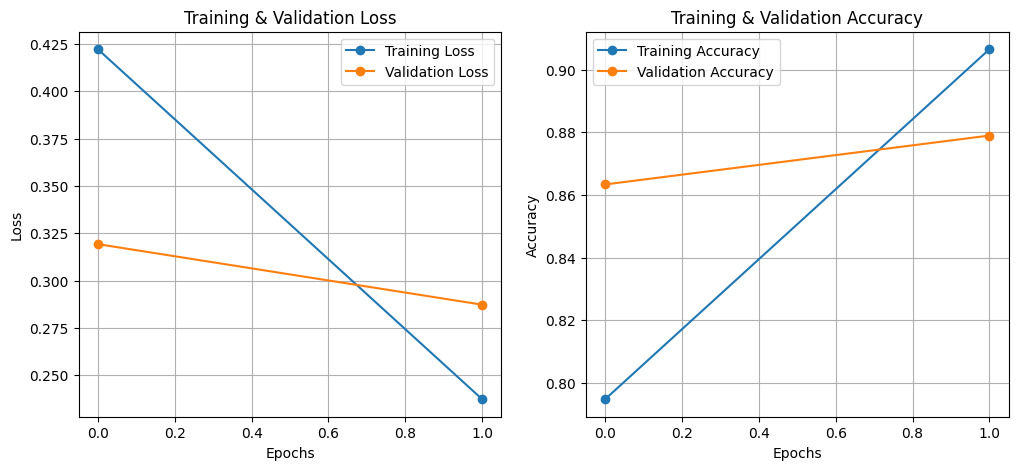

In [21]:
import matplotlib.pyplot as plt

# Récupération des métriques de l'historique d'entraînement
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Création de la figure
plt.figure(figsize=(12, 5))

# Graphique de la loss
plt.subplot(1, 2, 1)  # 1 ligne, 2 colonnes, premier subplot
plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid()

# Graphique de l'accuracy
plt.subplot(1, 2, 2)  # 1 ligne, 2 colonnes, deuxième subplot
plt.plot(train_acc, label='Training Accuracy', marker='o')
plt.plot(val_acc, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid()

# Affichage des graphiques
plt.show()


In [27]:
results = custom_model.evaluate(x_test_v2, test_labels, verbose=2)

for name, value in zip(custom_model.metrics_names, results):
    print("%s: %.3f" % (name, value))

235/235 - 8s - 35ms/step - accuracy: 0.8819 - loss: 0.2789
loss: 0.279
compile_metrics: 0.882


In [30]:
import numpy as np
import tensorflow as tf

# Paramètres
VOCAB_SIZE = 20000  # Exemple, ajustez selon vos paramètres
MAX_LEN = 200  # Exemple, ajustez selon vos paramètres


# Charger et adapter le vectoriseur
def load_vectorizer(vocab_size, max_len,train_sentences):
    text_vectorizer = TextVectorization(
            max_tokens=VOCAB_SIZE,
            output_mode="int",
            output_sequence_length=MAX_LEN,
            standardize="lower_and_strip_punctuation",
            split="whitespace",
    )
    text_vectorizer.adapt(train_sentences)
    return text_vectorizer

# Prétraiter une phrase
def preprocess_sentence(sentence, text_vectorizer, max_len):
    sentence_vector = text_vectorizer(np.array([sentence]))
    sentence_vector = tf.keras.preprocessing.sequence.pad_sequences(
        sentence_vector, maxlen=max_len
    )
    return sentence_vector

# Prédire le sentiment d'une phrase
def predict_sentiment(sentence, model, text_vectorizer, max_len):
    sentence_vector = preprocess_sentence(sentence, text_vectorizer, max_len)
    prediction_score = np.argmax(model.predict(sentence_vector))
    if prediction_score == 1:
        sentiment = f"Movie is Positive - Score {prediction_score}"
    else:
        sentiment = f"Movie is Negative - Score {prediction_score}"
    return sentiment


vectorizer = load_vectorizer(VOCAB_SIZE, MAX_LEN,train_sentences)
sentence = "This movie is great!"  # Exemple de phrase
sentiment = predict_sentiment(sentence, custom_model, vectorizer, MAX_LEN)

print(sentiment)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
Movie is Positive - Score 1


In [31]:
sentence = "This movie was an absolute disaster. The acting was terrible, the plot was nonsensical, and the special effects were laughable. It was a complete waste of time and money. I can't believe I sat through the entire thing. Avoid this movie at all costs!"

sentiment = predict_sentiment(sentence, custom_model, vectorizer, MAX_LEN)
print(f"Sentence: {sentence}")
print(f"Predicted sentiment: {sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Sentence: This movie was an absolute disaster. The acting was terrible, the plot was nonsensical, and the special effects were laughable. It was a complete waste of time and money. I can't believe I sat through the entire thing. Avoid this movie at all costs!
Predicted sentiment: Movie is Negative - Score 0


In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Obtenir les prédictions du modèle
y_train_pred = custom_model.predict(x_train_v2)
y_val_pred = custom_model.predict(x_val_v2)
y_test_pred = custom_model.predict(x_test_v2)

# Convertir les prédictions en classes (0 ou 1)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Calculer MSE, RMSE et MAE
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, rmse, mae

# Appliquer aux données d'entraînement, de validation et de test
mse_train, rmse_train, mae_train = calculate_metrics(train_labels, y_train_pred_classes)
mse_val, rmse_val, mae_val = calculate_metrics(val_labels, y_val_pred_classes)
mse_test, rmse_test, mae_test = calculate_metrics(test_labels, y_test_pred_classes)

# Afficher les résultats
print("Métriques sur l'ensemble d'entraînement :")
print(f"MSE: {mse_train}, RMSE: {rmse_train}, MAE: {mae_train}")

print("\nMétriques sur l'ensemble de validation :")
print(f"MSE: {mse_val}, RMSE: {rmse_val}, MAE: {mae_val}")

print("\nMétriques sur l'ensemble de test :")
print(f"MSE: {mse_test}, RMSE: {rmse_test}, MAE: {mae_test}")

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 38s 35ms/step
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step
235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step
Métriques sur l'ensemble d'entraînement :
MSE: 0.04511557473070659, RMSE: 0.2124042719219804, MAE: 0.04511557473070659

Métriques sur l'ensemble de validation :
MSE: 0.12106666666666667, RMSE: 0.3479463560186637, MAE: 0.12106666666666667

Métriques sur l'ensemble de test :
MSE: 0.1181175843220904, RMSE: 0.3436823887284456, MAE: 0.1181175843220904


Rapport de classification sur l'ensemble de test :
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      3753
           1       0.88      0.89      0.88      3748

    accuracy                           0.88      7501
   macro avg       0.88      0.88      0.88      7501
weighted avg       0.88      0.88      0.88      7501



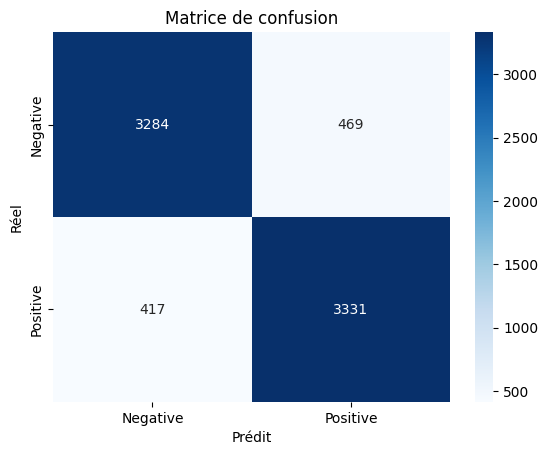

In [34]:
from sklearn.metrics import classification_report, confusion_matrix

# Rapport de classification
print("Rapport de classification sur l'ensemble de test :")
print(classification_report(test_labels, y_test_pred_classes))

# Matrice de confusion
conf_matrix = confusion_matrix(test_labels, y_test_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()